# Multimodal Hate Speech Detection

## Install dependencies and create environment

- Install [MMF Framework](https://mmf.sh/docs)
- https://mmf.sh/docs/tutorials/checkpointing
- https://github.com/facebookresearch/mmf
- https://github.com/apsdehal/hm_example_mmf
- https://www.drivendata.co/blog/hateful-memes-benchmark/
- https://github.com/facebookresearch/mmf/tree/main/projects/hateful_memes


In [1]:
!pip install --upgrade --pre mmf

     |████████████████████████████████| 404 kB 5.1 MB/s 
     |████████████████████████████████| 73 kB 2.1 MB/s 
     |████████████████████████████████| 1.5 MB 28.9 MB/s 
     |████████████████████████████████| 6.6 MB 61.6 MB/s 
     |████████████████████████████████| 131 kB 74.1 MB/s 
     |████████████████████████████████| 447 kB 53.5 MB/s 
     |████████████████████████████████| 869 kB 56.1 MB/s 
     |████████████████████████████████| 752.0 MB 9.4 kB/s 
     |████████████████████████████████| 450 kB 71.4 MB/s 
     |████████████████████████████████| 57 kB 5.6 MB/s 
  Using cached pybind11-2.8.1-py2.py3-none-any.whl (208 kB)
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 596 kB 69.3 MB/s 
     |████████████████████████████████| 1.2 MB 72.8 MB/s 
     |████████████████████████████████| 895 kB 63.7 MB/s 
     |████████████████████████████████| 131 kB 69.3 MB/s 
     |████████████████████████████████| 8.4 MB 59.8 MB/s 
     |████████████

In [2]:
!pip install grad-cam 

     |████████████████████████████████| 1.8 MB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.3.5-py3-none-any.whl size=22419 sha256=69239e93aaae87566c04751a01dcc1338872b0526c924d0416895e8b662c8d29
  Stored in directory: /root/.cache/pip/wheels/89/d1/a6/41cb46183c56fe9e78ba80781ca35c3bc2728406b694fb7a13
Successfully built grad-cam


In [3]:
!git clone https://github.com/amankhullar/BDS-final-project.git

Cloning into 'BDS-final-project'...
remote: Enumerating objects: 896, done.
remote: Counting objects: 100% (896/896), done.
remote: Compressing objects: 100% (606/606), done.
remote: Total 896 (delta 207), reused 889 (delta 200), pack-reused 0
Receiving objects: 100% (896/896), 4.60 MiB | 9.21 MiB/s, done.
Resolving deltas: 100% (207/207), done.


In [4]:
!cp /content/BDS-final-project/visualizations/pytorch-grad-cam-master/pytorch_grad_cam/base_cam.py  /usr/local/lib/python3.7/dist-packages/pytorch_grad_cam/base_cam.py

In [5]:
!cp  /content/BDS-final-project/mmbt_architectures/mmf/models/interfaces/mmbt.py /usr/local/lib/python3.7/dist-packages/mmf/models/interfaces/mmbt.py

In [6]:
!cp /content/BDS-final-project/mmbt_architectures/mmf/models/fusions.py /usr/local/lib/python3.7/dist-packages/mmf/models/fusions.py

#### Mount Drive
We mount drive to save the required output

In [15]:
from google.colab import drive
drive.mount('/content/drive')
!cd /content/drive/MyDrive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Configure dataset

In [19]:
!cp /content/mmf/mmf_cli/hm_convert.py /usr/local/lib/python3.7/dist-packages/mmf_cli/

In [ ]:
!mmf_convert_hm --zip_file hateful_memes.zip

Data folder is /root/.cache/torch/mmf/data
Zip path is hateful_memes.zip
Copying hateful_memes.zip
Unzipping hateful_memes.zip
Extracting the zip can take time. Sit back and relax.
Moving train.jsonl
Moving dev_seen.jsonl
Moving test_seen.jsonl
Moving dev_unseen.jsonl
Moving test_unseen.jsonl
Moving img


In [ ]:
!cp /root/.cache/torch/mmf/data/datasets/hateful_memes/defaults/annotations/dev_unseen.jsonl /root/.cache/torch/mmf/data/datasets/hateful_memes/defaults/annotations/dev.jsonl
!cp /root/.cache/torch/mmf/data/datasets/hateful_memes/defaults/annotations/test_unseen.jsonl /root/.cache/torch/mmf/data/datasets/hateful_memes/defaults/annotations/test.jsonl

In [ ]:
!ls /root/.cache/torch/mmf/data/datasets/hateful_memes/defaults/annotations

dev.jsonl	dev_unseen.jsonl  test_seen.jsonl    train.jsonl
dev_seen.jsonl	test.jsonl	  test_unseen.jsonl


### Download the Meme dataset inside the server

In [ ]:
import os
import warnings

from mmf.common.registry import registry
from mmf.datasets.builders.hateful_memes.dataset import (
    HatefulMemesFeaturesDataset,
    HatefulMemesImageDataset,
)
from mmf.datasets.mmf_dataset_builder import MMFDatasetBuilder
from mmf.utils.configuration import get_mmf_env
from mmf.utils.file_io import PathManager
from mmf.utils.general import get_absolute_path


@registry.register_builder("hateful_memes")
class HatefulMemesBuilder(MMFDatasetBuilder):
    def __init__(
        self,
        dataset_name="hateful_memes",
        dataset_class=HatefulMemesImageDataset,
        *args,
        **kwargs
    ):
        super().__init__(dataset_name, dataset_class, *args, **kwargs)
        self.dataset_class = HatefulMemesImageDataset

    @classmethod
    def config_path(self):
        return "configs/datasets/hateful_memes/defaults.yaml"

    def load(self, config, dataset_type, *args, **kwargs):
        config = config

        if config.use_features:
            self.dataset_class = HatefulMemesFeaturesDataset

        self.dataset = super().load(config, dataset_type, *args, **kwargs)

        return self.dataset

    def build(self, config, *args, **kwargs):
        # First, check whether manual downloads have been performed


        # NOTE: made the change here for the path update
        # data_dir = get_mmf_env(key="data_dir")
        data_dir = os.path.join(os.getcwd(), '/root/.cache/torch/mmf/data/')

        # test_path = get_absolute_path(
        #     os.path.join(
        #         data_dir,
        #         "datasets",
        #         self.dataset_name,
        #         "defaults",
        #         "annotations",
        #         "train.jsonl",
        #     )
        # )
        # test_path = get_absolute_path(os.path.join(data_dir, "train.jsonl"))

        test_path = "/root/.cache/torch/mmf/data/datasets/hateful_memes/defaults/annotations/train.jsonl"
        print(test_path)

        # NOTE: This doesn't check for files, but that is a fine assumption for now
        assert PathManager.exists(test_path), (
            "Hateful Memes Dataset doesn't do automatic downloads; please "
            + "follow instructions at https://fb.me/hm_prerequisites"
        )
        super().build(config, *args, **kwargs)

    def update_registry_for_model(self, config):
        if hasattr(self.dataset, "text_processor") and hasattr(
            self.dataset.text_processor, "get_vocab_size"
        ):
            registry.register(
                self.dataset_name + "_text_vocab_size",
                self.dataset.text_processor.get_vocab_size(),
            )
        registry.register(self.dataset_name + "_num_final_outputs", 2)

### Visualize dataset

/root/.cache/torch/mmf/data/datasets/hateful_memes/defaults/annotations/train.jsonl
[ Downloading: https://dl.fbaipublicfiles.com/mmf/data/datasets/hateful_memes/defaults/extras.tar.gz to /root/.cache/torch/mmf/data/datasets/hateful_memes/defaults/extras.tar.gz ]


[ Starting checksum for extras.tar.gz]
[ Checksum successful for extras.tar.gz]
Unpacking extras.tar.gz


/root/.cache/torch/mmf/glove.6B.zip: 862MB [02:40, 5.37MB/s]                           
100%|█████████▉| 399999/400000 [00:42<00:00, 9317.86it/s]


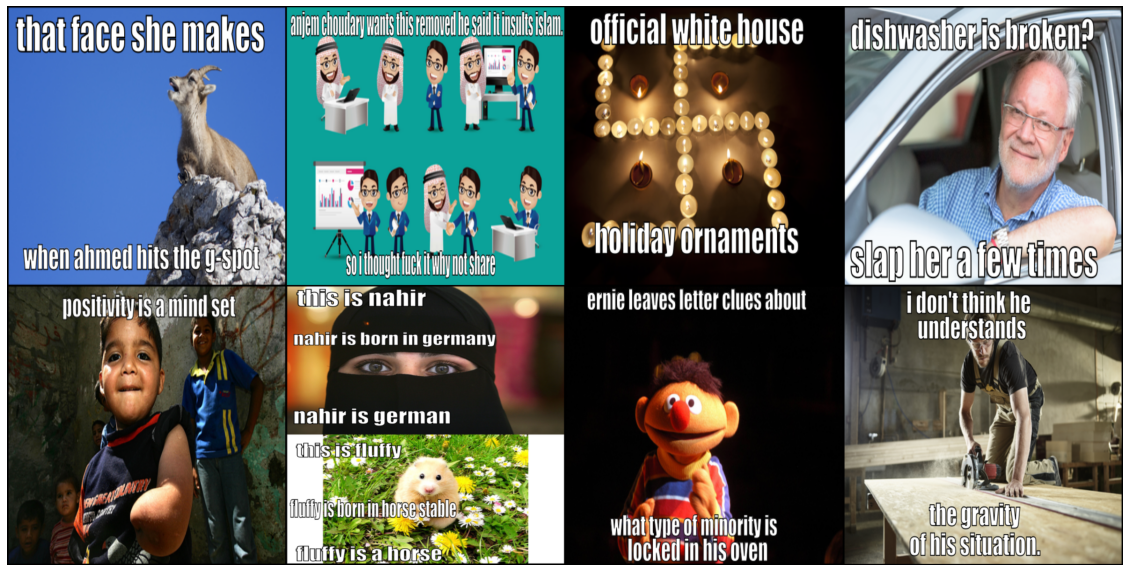

In [ ]:
from mmf.common.registry import registry
from mmf.models.mmbt import MMBT
from mmf.utils.build import build_dataset
from mmf.utils.env import setup_imports

setup_imports()
dataset = build_dataset("hateful_memes")

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 20)
dataset.visualize(num_samples=8, size=(512, 512), nrow=4)

- Install 

###Load  the pretrained model models
We load the following pre-trained models for our grad-cam visualization:
* MMBT
* Concat Bert
* Late-Fusion


In [ ]:
import matplotlib.pyplot as plt
import requests

from PIL import Image

from mmf.models.mmbt import MMBT

model_mmbt= MMBT.from_pretrained("mmbt.hateful_memes.images")

[ Downloading: https://dl.fbaipublicfiles.com/mmf/data/models/mmbt/mmbt.finetuned.hateful_memes_images.tar.gz to /root/.cache/torch/mmf/data/models/mmbt.hateful_memes.images/mmbt.finetuned.hateful_memes_images.tar.gz ]


[ Starting checksum for mmbt.finetuned.hateful_memes_images.tar.gz]
[ Checksum successful for mmbt.finetuned.hateful_memes_images.tar.gz]
Unpacking mmbt.finetuned.hateful_memes_images.tar.gz


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [ ]:
from mmf.models import LateFusion
model_late_fusion = LateFusion.from_pretrained("late_fusion.hateful_memes")#multimodal: LATE FUSION


[ Downloading: https://dl.fbaipublicfiles.com/mmf/data/models/late_fusion/late_fusion.finetuned.hateful_memes.tar.gz to /root/.cache/torch/mmf/data/models/late_fusion.hateful_memes/late_fusion.finetuned.hateful_memes.tar.gz ]


[ Starting checksum for late_fusion.finetuned.hateful_memes.tar.gz]
[ Checksum successful for late_fusion.finetuned.hateful_memes.tar.gz]
Unpacking late_fusion.finetuned.hateful_memes.tar.gz


In [ ]:
from mmf.models import ConcatBERT
model_concat_bert = ConcatBERT.from_pretrained("concat_bert.hateful_memes")#multimodal:CONCAT BERT

[ Downloading: https://dl.fbaipublicfiles.com/mmf/data/models/concat_bert/concat_bert.finetuned.hateful_memes.tar.gz to /root/.cache/torch/mmf/data/models/concat_bert.hateful_memes/concat_bert.finetuned.hateful_memes.tar.gz ]


[ Starting checksum for concat_bert.finetuned.hateful_memes.tar.gz]
[ Checksum successful for concat_bert.finetuned.hateful_memes.tar.gz]
Unpacking concat_bert.finetuned.hateful_memes.tar.gz


In [ ]:
cp /content/drive/MyDrive/sample_data/* /usr/local/lib/python3.7/dist-packages/mmf/imgs/

cp: target '/usr/local/lib/python3.7/dist-packages/mmf/imgs/' is not a directory


## GRADCAM VISUALIZATION

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.image import show_cam_on_image,preprocess_image
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:

print(input['image'].size())

torch.Size([1, 3, 224, 224])


### Defining Target Layers

In [ ]:
target_layers_mmbt = [model_mmbt.model.model.bert.mmbt.modal_encoder.encoder.model[-1][-1]]
print(target_layers_mmbt)

[Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)]


In [ ]:
# print(model_late_fusion)
target_layers_late_fusion = [model_late_fusion.model.base.modal.model[-1][-1]]
print(target_layers_late_fusion)

[Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)]


In [ ]:
# concat bert
target_layers_concat_bert= [model_concat_bert.model.base.modal.model[-1][-1]]
print(target_layers_concat_bert)

[Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)]


## Visualization for MMBT/Late Fusion/ Concat Bert
 

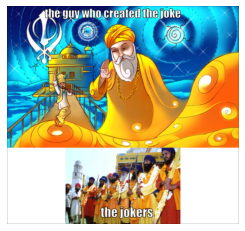

Hateful as per the model? No
Model's confidence: 99.994%
{'label': 0, 'confidence': 0.9999374151229858}
<class 'mmf.common.sample.SampleList'>
(224, 224, 3)


True

In [ ]:
#sample 1 MMBT

image_url = "https://i.ibb.co/wYVPpWr/96781.png" 
text = "the guy who created the joke, the jokers"
input,output = model_mmbt.classify(image_url, text)
plt.imshow(Image.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()
hateful = "Yes" if output["label"] == 1 else "No"
print("Hateful as per the model?", hateful)
print(f"Model's confidence: {output['confidence'] * 100:.3f}%")
print(output)

cam = GradCAM(model=model_mmbt, target_layers=target_layers_mmbt)
print(type(input))
grayscale_cam = cam(input_tensor=input, target_category=None)
grayscale_cam = grayscale_cam[0, :]
import cv2
rgb_img = cv2.imread('96781.png')
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img=rgb_img/255
print(rgb_img.shape)
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
cv2.imwrite('./mmbt_96781.jpg', visualization)

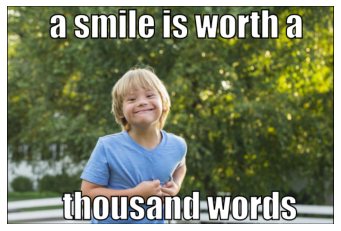

Hateful as per the model? No
Model's confidence: 80.921%
{'label': 0, 'confidence': 0.809212327003479}
<class 'mmf.common.sample.SampleList'>
(224, 224, 3)


True

In [ ]:
#sample 1 CONCAT BERT

image_url = "https://i.ibb.co/YhG6qJn/01276.png" 
text = "a smile is worth a thousand words"
input,output = model_concat_bert.classify(image_url, text)
plt.imshow(Image.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()
hateful = "Yes" if output["label"] == 1 else "No"
print("Hateful as per the model?", hateful)
print(f"Model's confidence: {output['confidence'] * 100:.3f}%")
print(output)

cam = GradCAM(model=model_concat_bert, target_layers=target_layers_concat_bert)
print(type(input))
grayscale_cam = cam(input_tensor=input, target_category=None)
grayscale_cam = grayscale_cam[0, :]
import cv2
rgb_img = cv2.imread('01276.png')
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img=rgb_img/255
print(rgb_img.shape)
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
cv2.imwrite('./concat_bert_01276.jpg', visualization)

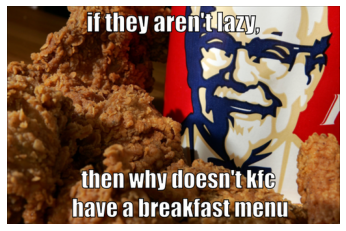

Hateful as per the model? No
Model's confidence: 99.783%
{'label': 0, 'confidence': 0.9978275895118713}
<class 'mmf.common.sample.SampleList'>
(224, 224, 3)


True

In [ ]:
# Sample 2 MMBT
image_url = "https://i.ibb.co/B6YHJqR/18732.png" 
text = "if they aren't lazy, then why doesn't kfc have a breakfast menu"
input,output = model_mmbt.classify(image_url, text)
plt.imshow(Image.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()
hateful = "Yes" if output["label"] == 1 else "No"
print("Hateful as per the model?", hateful)
print(f"Model's confidence: {output['confidence'] * 100:.3f}%")
print(output)
cam = GradCAM(model=model_mmbt, target_layers=target_layers_mmbt)
print(type(input))
grayscale_cam = cam(input_tensor=input, target_category=None)
grayscale_cam = grayscale_cam[0, :]
rgb_img = cv2.imread('./18732.png')
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img=rgb_img/255
print(rgb_img.shape)
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
cv2.imwrite('./map_18732.jpg', visualization)

Connection error, retrying. (4 retries left)


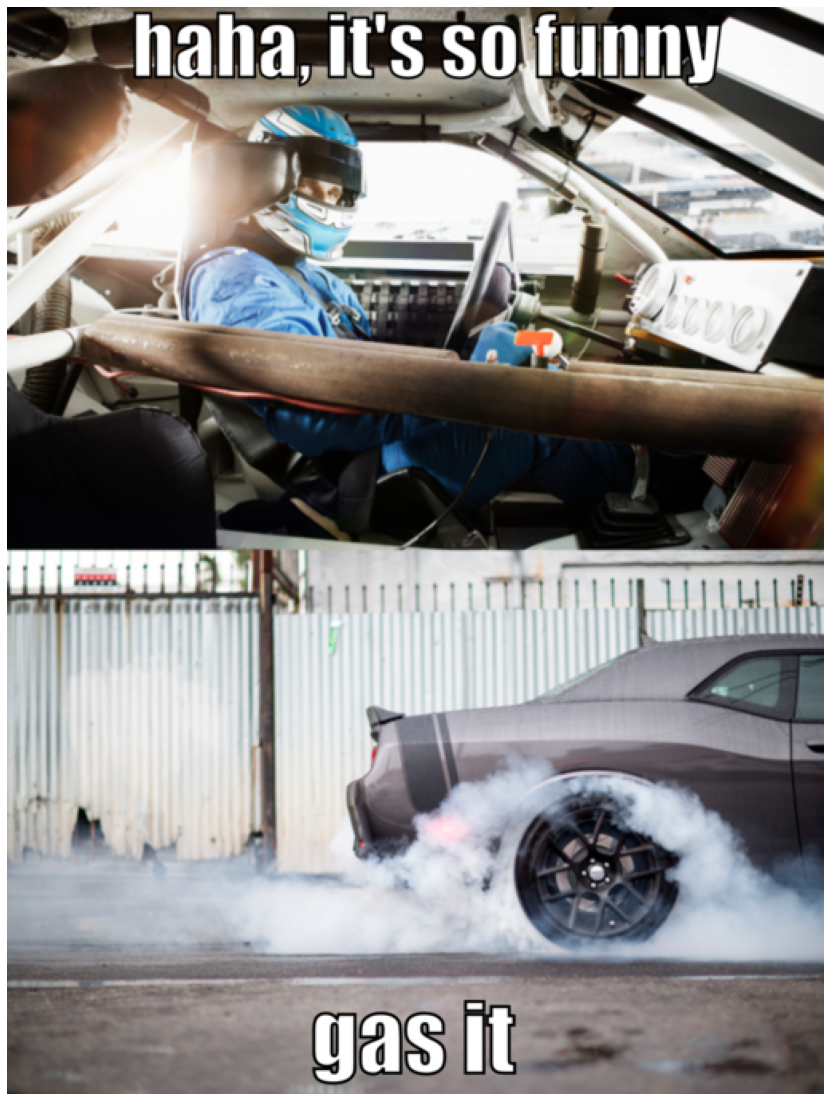

Hateful as per the model? No
Model's confidence: 73.393%
{'label': 0, 'confidence': 0.733934760093689}
<class 'mmf.common.sample.SampleList'>
(224, 224, 3)


True

In [ ]:
# sample 3 MMBT 
image_url = "https://i.ibb.co/8gjKbfh/23876.png" 
text = "haha, it's so funny gas it"
input,output = model_mmbt.classify(image_url, text)
plt.imshow(Image.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()
hateful = "Yes" if output["label"] == 1 else "No"
print("Hateful as per the model?", hateful)
print(f"Model's confidence: {output['confidence'] * 100:.3f}%")
print(output)
cam = GradCAM(model=model_mmbt, target_layers=target_layers_mmbt)
print(type(input))
grayscale_cam = cam(input_tensor=input, target_category=None)
grayscale_cam = grayscale_cam[0, :]
rgb_img = cv2.imread('./23876.png')
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img=rgb_img/255
print(rgb_img.shape)
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
cv2.imwrite('./map_23876.jpg', visualization)

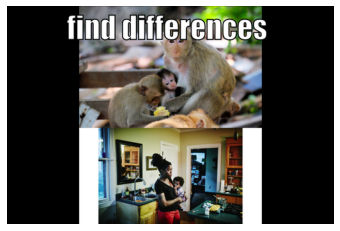

Hateful as per the model? No
Model's confidence: 99.933%
{'label': 0, 'confidence': 0.999326229095459}
<class 'mmf.common.sample.SampleList'>
(224, 224, 3)


True

In [ ]:
#sample 4  MMBT 
image_url = "https://i.ibb.co/xYHMV25/32604.png" 
text = "find differences"
input,output = model_mmbt.classify(image_url, text)
plt.imshow(Image.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()
hateful = "Yes" if output["label"] == 1 else "No"
print("Hateful as per the model?", hateful)
print(f"Model's confidence: {output['confidence'] * 100:.3f}%")
print(output)
cam = GradCAM(model=model_mmbt, target_layers=target_layers_mmbt)
print(type(input))
grayscale_cam = cam(input_tensor=input, target_category=None)
grayscale_cam = grayscale_cam[0, :]
rgb_img = cv2.imread('./32604.png')
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img=rgb_img/255
print(rgb_img.shape)
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
cv2.imwrite('./mmbt_32604.jpg', visualization)

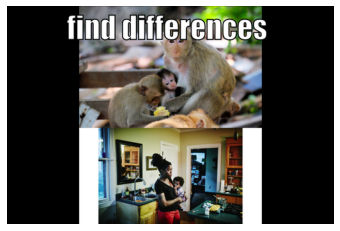

Hateful as per the model? No
Model's confidence: 78.130%
{'label': 0, 'confidence': 0.7812970280647278}
<class 'mmf.common.sample.SampleList'>
(224, 224, 3)


True

In [ ]:
#sample 4  Late Fusion
image_url = "https://i.ibb.co/xYHMV25/32604.png" 
text = "find differences"
input,output = model_late_fusion.classify(image_url, text)
plt.imshow(Image.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()
hateful = "Yes" if output["label"] == 1 else "No"
print("Hateful as per the model?", hateful)
print(f"Model's confidence: {output['confidence'] * 100:.3f}%")
print(output)
cam = GradCAM(model=model_late_fusion, target_layers=target_layers_late_fusion)
print(type(input))
grayscale_cam = cam(input_tensor=input, target_category=None)
grayscale_cam = grayscale_cam[0, :]
rgb_img = cv2.imread('./32604.png')
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img=rgb_img/255
print(rgb_img.shape)
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
cv2.imwrite('./late_fusion_32604.jpg', visualization)

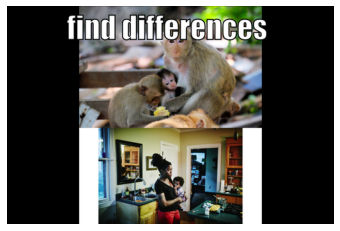

Hateful as per the model? No
Model's confidence: 87.206%
{'label': 0, 'confidence': 0.8720555305480957}
<class 'mmf.common.sample.SampleList'>
(224, 224, 3)


True

In [ ]:
#sample 4  Concat Bert
image_url = "https://i.ibb.co/xYHMV25/32604.png" 
text = "find differences"
input,output = model_concat_bert.classify(image_url, text)
plt.imshow(Image.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()
hateful = "Yes" if output["label"] == 1 else "No"
print("Hateful as per the model?", hateful)
print(f"Model's confidence: {output['confidence'] * 100:.3f}%")
print(output)
cam = GradCAM(model=model_concat_bert, target_layers=target_layers_concat_bert)
print(type(input))
grayscale_cam = cam(input_tensor=input, target_category=None)
grayscale_cam = grayscale_cam[0, :]
rgb_img = cv2.imread('./32604.png')
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img=rgb_img/255
print(rgb_img.shape)
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
cv2.imwrite('./concat_bert_32604.jpg', visualization)

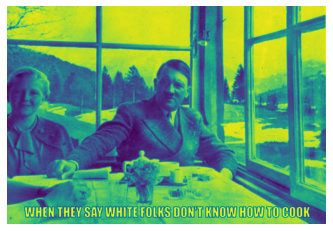

Hateful as per the model? Yes
Model's confidence: 99.962%
{'label': 1, 'confidence': 0.999620795249939}
<class 'mmf.common.sample.SampleList'>
(224, 224, 3)


True

In [ ]:
#sample 5 MMBT
image_url = "https://i.ibb.co/CJdvcLP/38794.png" 
text = "when they say white folks don't know how to cook"
input,output = model_mmbt.classify(image_url, text)
plt.imshow(Image.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()
hateful = "Yes" if output["label"] == 1 else "No"
print("Hateful as per the model?", hateful)
print(f"Model's confidence: {output['confidence'] * 100:.3f}%")
print(output)
cam = GradCAM(model=model_mmbt, target_layers=target_layers_mmbt)
print(type(input))
grayscale_cam = cam(input_tensor=input, target_category=None)
grayscale_cam = grayscale_cam[0, :]
rgb_img = cv2.imread('./38794.png')
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img=rgb_img/255
print(rgb_img.shape)
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
cv2.imwrite('./mmbt_38794.jpg', visualization)

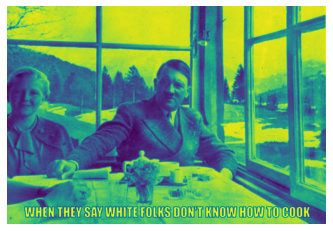

Hateful as per the model? Yes
Model's confidence: 99.710%
{'label': 1, 'confidence': 0.9970983266830444}
<class 'mmf.common.sample.SampleList'>
(224, 224, 3)


True

In [ ]:
#sample 5 Late Fusion
image_url = "https://i.ibb.co/CJdvcLP/38794.png" 
text = "when they say white folks don't know how to cook"
input,output = model_late_fusion.classify(image_url, text)
plt.imshow(Image.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()
hateful = "Yes" if output["label"] == 1 else "No"
print("Hateful as per the model?", hateful)
print(f"Model's confidence: {output['confidence'] * 100:.3f}%")
print(output)
cam = GradCAM(model=model_late_fusion, target_layers=target_layers_late_fusion)
print(type(input))
grayscale_cam = cam(input_tensor=input, target_category=None)
grayscale_cam = grayscale_cam[0, :]
rgb_img = cv2.imread('./38794.png')
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img=rgb_img/255
print(rgb_img.shape)
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
cv2.imwrite('./late_fusion_38794.jpg', visualization)

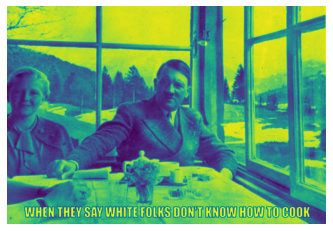

Hateful as per the model? Yes
Model's confidence: 89.557%
{'label': 1, 'confidence': 0.895573079586029}
<class 'mmf.common.sample.SampleList'>
(224, 224, 3)


True

In [ ]:
#sample 5 Concat Bert
image_url = "https://i.ibb.co/CJdvcLP/38794.png" 
text = "when they say white folks don't know how to cook"
input,output = model_concat_bert.classify(image_url, text)
plt.imshow(Image.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()
hateful = "Yes" if output["label"] == 1 else "No"
print("Hateful as per the model?", hateful)
print(f"Model's confidence: {output['confidence'] * 100:.3f}%")
print(output)
cam = GradCAM(model=model_concat_bert, target_layers=target_layers_concat_bert)
print(type(input))
grayscale_cam = cam(input_tensor=input, target_category=None)
grayscale_cam = grayscale_cam[0, :]
rgb_img = cv2.imread('./38794.png')
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img=rgb_img/255
print(rgb_img.shape)
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
cv2.imwrite('./concat_bert_38794.jpg', visualization)

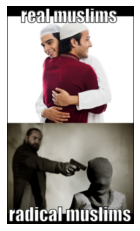

Hateful as per the model? Yes
Model's confidence: 54.370%
{'label': 1, 'confidence': 0.5436988472938538}
<class 'mmf.common.sample.SampleList'>
(224, 224, 3)


True

In [ ]:
#sample 6 mmbt
image_url = "https://i.ibb.co/M924mRC/50714.png" 
text = "real muslims radical muslims"
input,output = model_mmbt.classify(image_url, text)
plt.imshow(Image.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()
hateful = "Yes" if output["label"] == 1 else "No"
print("Hateful as per the model?", hateful)
print(f"Model's confidence: {output['confidence'] * 100:.3f}%")
print(output)
cam = GradCAM(model=model_mmbt, target_layers=target_layers_mmbt)
print(type(input))
grayscale_cam = cam(input_tensor=input, target_category=None)
grayscale_cam = grayscale_cam[0, :]
rgb_img = cv2.imread('./50714.png')
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img=rgb_img/255
print(rgb_img.shape)
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
cv2.imwrite('./mmbt_50714.jpg', visualization)

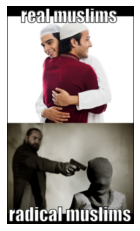

Hateful as per the model? Yes
Model's confidence: 97.828%
{'label': 1, 'confidence': 0.9782751798629761}
<class 'mmf.common.sample.SampleList'>
(224, 224, 3)


True

In [ ]:
#sample 6 late fusion
image_url = "https://i.ibb.co/M924mRC/50714.png" 
text = "real muslims radical muslims"
input,output = model_late_fusion.classify(image_url, text)
plt.imshow(Image.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()
hateful = "Yes" if output["label"] == 1 else "No"
print("Hateful as per the model?", hateful)
print(f"Model's confidence: {output['confidence'] * 100:.3f}%")
print(output)
cam = GradCAM(model=model_late_fusion, target_layers=target_layers_late_fusion)
print(type(input))
grayscale_cam = cam(input_tensor=input, target_category=None)
grayscale_cam = grayscale_cam[0, :]
rgb_img = cv2.imread('./50714.png')
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img=rgb_img/255
print(rgb_img.shape)
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
cv2.imwrite('./late_fusion_50714.jpg', visualization)

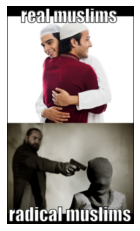

Hateful as per the model? Yes
Model's confidence: 92.183%
{'label': 1, 'confidence': 0.9218297004699707}
<class 'mmf.common.sample.SampleList'>
(224, 224, 3)


True

In [ ]:
#sample 6 concat bert
image_url = "https://i.ibb.co/M924mRC/50714.png" 
text = "real muslims radical muslims"
input,output = model_concat_bert.classify(image_url, text)
plt.imshow(Image.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()
hateful = "Yes" if output["label"] == 1 else "No"
print("Hateful as per the model?", hateful)
print(f"Model's confidence: {output['confidence'] * 100:.3f}%")
print(output)
cam = GradCAM(model=model_concat_bert, target_layers=target_layers_concat_bert)
print(type(input))
grayscale_cam = cam(input_tensor=input, target_category=None)
grayscale_cam = grayscale_cam[0, :]
rgb_img = cv2.imread('./50714.png')
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img=rgb_img/255
print(rgb_img.shape)
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
cv2.imwrite('./concat_bert_50714.jpg', visualization)

Connection error, retrying. (4 retries left)


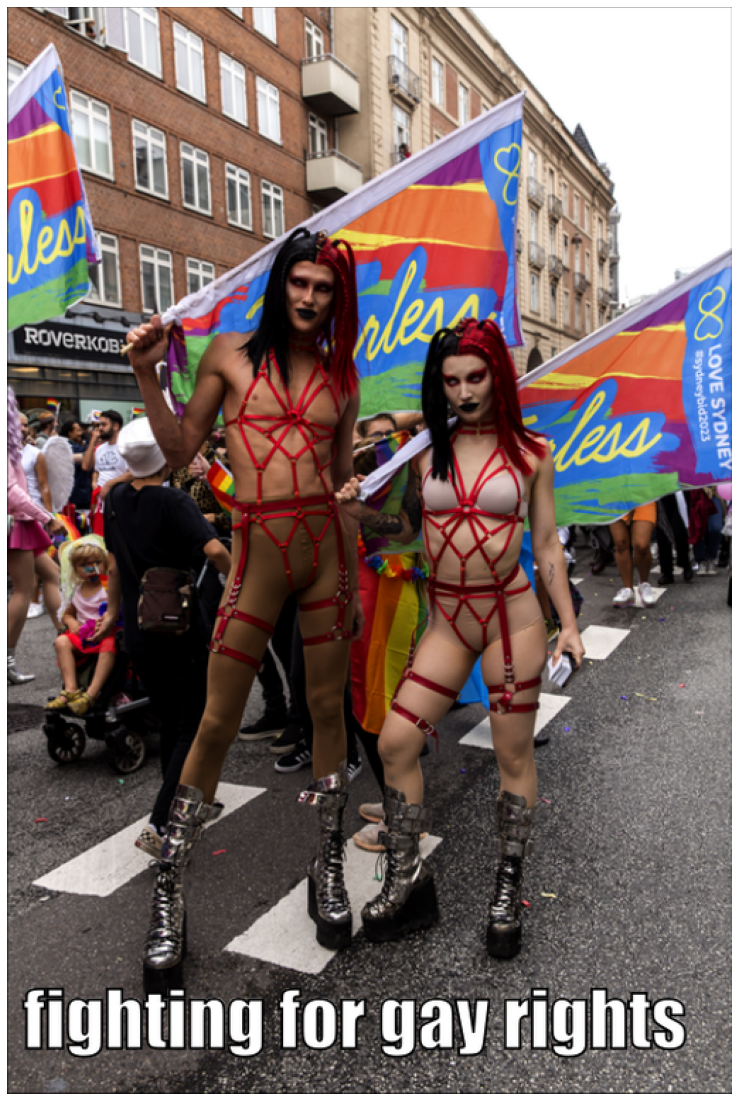

Hateful as per the model? No
Model's confidence: 99.993%
{'label': 0, 'confidence': 0.9999274015426636}
<class 'mmf.common.sample.SampleList'>
(224, 224, 3)


True

In [ ]:
#sample 7 mmbt 
image_url = "https://i.ibb.co/xJfBR04/71352.png" 
text = "fighting for gay rights"
input,output = model_mmbt.classify(image_url, text)
plt.imshow(Image.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()
hateful = "Yes" if output["label"] == 1 else "No"
print("Hateful as per the model?", hateful)
print(f"Model's confidence: {output['confidence'] * 100:.3f}%")
print(output)
cam = GradCAM(model=model_mmbt, target_layers=target_layers_mmbt)
print(type(input))
grayscale_cam = cam(input_tensor=input, target_category=None)
grayscale_cam = grayscale_cam[0, :]
rgb_img = cv2.imread('./71352.png')
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img=rgb_img/255
print(rgb_img.shape)
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
cv2.imwrite('./mmbt_71352.jpg', visualization)

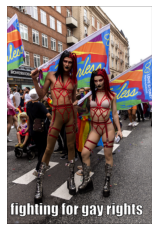

Hateful as per the model? No
Model's confidence: 98.599%
{'label': 0, 'confidence': 0.9859944581985474}
<class 'mmf.common.sample.SampleList'>
(224, 224, 3)


True

In [ ]:
#sample 7 late fusion 
image_url = "https://i.ibb.co/xJfBR04/71352.png" 
text = "fighting for gay rights"
input,output = model_late_fusion.classify(image_url, text)
plt.imshow(Image.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()
hateful = "Yes" if output["label"] == 1 else "No"
print("Hateful as per the model?", hateful)
print(f"Model's confidence: {output['confidence'] * 100:.3f}%")
print(output)
cam = GradCAM(model=model_late_fusion, target_layers=target_layers_late_fusion)
print(type(input))
grayscale_cam = cam(input_tensor=input, target_category=None)
grayscale_cam = grayscale_cam[0, :]
rgb_img = cv2.imread('./71352.png')
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img=rgb_img/255
print(rgb_img.shape)
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
cv2.imwrite('./late_fusion_71352.jpg', visualization)

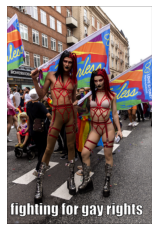

Hateful as per the model? No
Model's confidence: 78.616%
{'label': 0, 'confidence': 0.7861649394035339}
<class 'mmf.common.sample.SampleList'>
(224, 224, 3)


True

In [ ]:
#sample 7 concat bert
image_url = "https://i.ibb.co/xJfBR04/71352.png" 
text = "fighting for gay rights"
input,output = model_concat_bert.classify(image_url, text)
plt.imshow(Image.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()
hateful = "Yes" if output["label"] == 1 else "No"
print("Hateful as per the model?", hateful)
print(f"Model's confidence: {output['confidence'] * 100:.3f}%")
print(output)
cam = GradCAM(model=model_concat_bert, target_layers=target_layers_concat_bert)
print(type(input))
grayscale_cam = cam(input_tensor=input, target_category=None)
grayscale_cam = grayscale_cam[0, :]
rgb_img = cv2.imread('./71352.png')
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img=rgb_img/255
print(rgb_img.shape)
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
cv2.imwrite('./concat_bert_71352.jpg', visualization)

Connection error, retrying. (4 retries left)


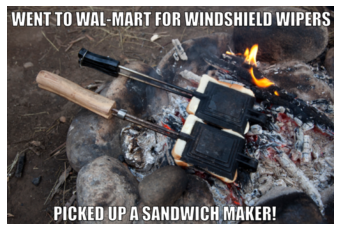

Hateful as per the model? No
Model's confidence: 99.992%
{'label': 0, 'confidence': 0.9999232292175293}
<class 'mmf.common.sample.SampleList'>
(224, 224, 3)


True

In [ ]:
#sample 8 mmbt 
image_url = "https://i.ibb.co/tXFCbWm/45217.png" 
text = "went to wal-mart for windsheild wipers, picked up a sandwich maker"
input,output = model_mmbt.classify(image_url, text)
plt.imshow(Image.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()
hateful = "Yes" if output["label"] == 1 else "No"
print("Hateful as per the model?", hateful)
print(f"Model's confidence: {output['confidence'] * 100:.3f}%")
print(output)
cam = GradCAM(model=model_mmbt, target_layers=target_layers_mmbt)
print(type(input))
grayscale_cam = cam(input_tensor=input, target_category=None)
grayscale_cam = grayscale_cam[0, :]
rgb_img = cv2.imread('./45217.png')
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img=rgb_img/255
print(rgb_img.shape)
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
cv2.imwrite('./mmbt_45217.jpg', visualization)

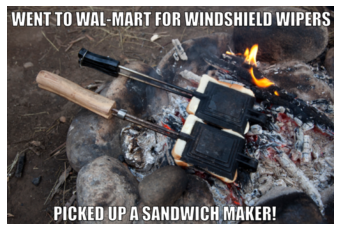

Hateful as per the model? No
Model's confidence: 97.849%
{'label': 0, 'confidence': 0.9784881472587585}
<class 'mmf.common.sample.SampleList'>
(224, 224, 3)


True

In [ ]:
#sample 8 late fusion 
image_url = "https://i.ibb.co/tXFCbWm/45217.png" 
text = "went to wal-mart for windsheild wipers, picked up a sandwich maker"
input,output = model_late_fusion.classify(image_url, text)
plt.imshow(Image.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()
hateful = "Yes" if output["label"] == 1 else "No"
print("Hateful as per the model?", hateful)
print(f"Model's confidence: {output['confidence'] * 100:.3f}%")
print(output)
cam = GradCAM(model=model_late_fusion, target_layers=target_layers_late_fusion)
print(type(input))
grayscale_cam = cam(input_tensor=input, target_category=None)
grayscale_cam = grayscale_cam[0, :]
rgb_img = cv2.imread('./45217.png')
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img=rgb_img/255
print(rgb_img.shape)
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
cv2.imwrite('./late_fusion_45217.jpg', visualization)

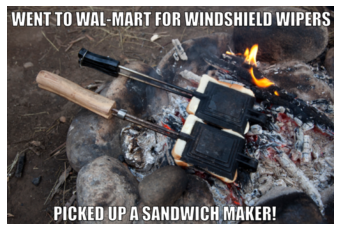

Hateful as per the model? No
Model's confidence: 97.248%
{'label': 0, 'confidence': 0.9724803566932678}
<class 'mmf.common.sample.SampleList'>
(224, 224, 3)


True

In [ ]:
#sample 8 concat bert 
image_url = "https://i.ibb.co/tXFCbWm/45217.png" 
text = "went to wal-mart for windsheild wipers, picked up a sandwich maker"
input,output = model_concat_bert.classify(image_url, text)
plt.imshow(Image.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()
hateful = "Yes" if output["label"] == 1 else "No"
print("Hateful as per the model?", hateful)
print(f"Model's confidence: {output['confidence'] * 100:.3f}%")
print(output)
cam = GradCAM(model=model_concat_bert, target_layers=target_layers_concat_bert)
print(type(input))
grayscale_cam = cam(input_tensor=input, target_category=None)
grayscale_cam = grayscale_cam[0, :]
rgb_img = cv2.imread('./45217.png')
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img=rgb_img/255
print(rgb_img.shape)
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
cv2.imwrite('./concat_bert_45217.jpg', visualization)

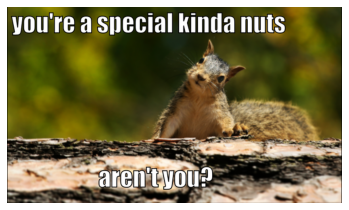

Hateful as per the model? No
Model's confidence: 99.967%
{'label': 0, 'confidence': 0.999669075012207}
<class 'mmf.common.sample.SampleList'>
(224, 224, 3)


True

In [ ]:
#sample 9 mmbt 
image_url = "https://i.ibb.co/n7bD7H9/01264.png" 
text = "you're a special kinda nuts, aren't you?"
input,output = model_mmbt.classify(image_url, text)
plt.imshow(Image.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()
hateful = "Yes" if output["label"] == 1 else "No"
print("Hateful as per the model?", hateful)
print(f"Model's confidence: {output['confidence'] * 100:.3f}%")
print(output)
cam = GradCAM(model=model_mmbt, target_layers=target_layers_mmbt)
print(type(input))
grayscale_cam = cam(input_tensor=input, target_category=None)
grayscale_cam = grayscale_cam[0, :]
rgb_img = cv2.imread('./01264.png')
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img=rgb_img/255
print(rgb_img.shape)
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
cv2.imwrite('./mmbt_02164.jpg', visualization)

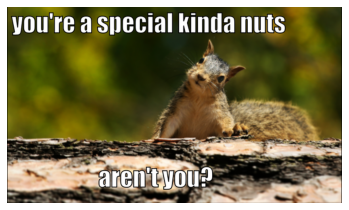

Hateful as per the model? No
Model's confidence: 95.675%
{'label': 0, 'confidence': 0.9567545056343079}
<class 'mmf.common.sample.SampleList'>
(224, 224, 3)


True

In [ ]:
#sample 9 late fusion 
image_url = "https://i.ibb.co/n7bD7H9/01264.png" 
text = "you're a special kinda nuts, aren't you?"
input,output = model_late_fusion.classify(image_url, text)
plt.imshow(Image.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()
hateful = "Yes" if output["label"] == 1 else "No"
print("Hateful as per the model?", hateful)
print(f"Model's confidence: {output['confidence'] * 100:.3f}%")
print(output)
cam = GradCAM(model=model_late_fusion, target_layers=target_layers_late_fusion)
print(type(input))
grayscale_cam = cam(input_tensor=input, target_category=None)
grayscale_cam = grayscale_cam[0, :]
rgb_img = cv2.imread('./01264.png')
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img=rgb_img/255
print(rgb_img.shape)
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
cv2.imwrite('./late_fusion_02164.jpg', visualization)

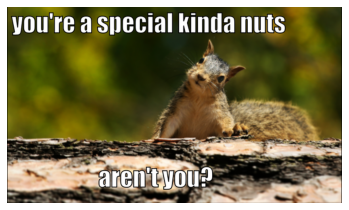

Hateful as per the model? No
Model's confidence: 96.818%
{'label': 0, 'confidence': 0.9681844115257263}
<class 'mmf.common.sample.SampleList'>
(224, 224, 3)


True

In [ ]:
#sample 9 concat bert
image_url = "https://i.ibb.co/n7bD7H9/01264.png" 
text = "you're a special kinda nuts, aren't you?"
input,output = model_concat_bert.classify(image_url, text)
plt.imshow(Image.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()
hateful = "Yes" if output["label"] == 1 else "No"
print("Hateful as per the model?", hateful)
print(f"Model's confidence: {output['confidence'] * 100:.3f}%")
print(output)
cam = GradCAM(model=model_concat_bert, target_layers=target_layers_concat_bert)
print(type(input))
grayscale_cam = cam(input_tensor=input, target_category=None)
grayscale_cam = grayscale_cam[0, :]
rgb_img = cv2.imread('./01264.png')
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img=rgb_img/255
print(rgb_img.shape)
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
cv2.imwrite('./concat_bert_02164.jpg', visualization)

In [ ]:
#sample 10 mmbt 
image_url = "https://i.ibb.co/n7bD7H9/01264.png" 
text = "you're a special kinda nuts, aren't you?"
input,output = model_mmbt.classify(image_url, text)
plt.imshow(Image.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()
hateful = "Yes" if output["label"] == 1 else "No"
print("Hateful as per the model?", hateful)
print(f"Model's confidence: {output['confidence'] * 100:.3f}%")
print(output)
cam = GradCAM(model=model_mmbt, target_layers=target_layers_mmbt)
print(type(input))
grayscale_cam = cam(input_tensor=input, target_category=None)
grayscale_cam = grayscale_cam[0, :]
rgb_img = cv2.imread('./01264.png')
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img=rgb_img/255
print(rgb_img.shape)
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
cv2.imwrite('./mmbt_02164.jpg', visualization)